In [167]:
import os
import sys
notebook_dir = os.getcwd()
project_dir = os.path.dirname(notebook_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)


from srcs.engdataset import ENGDataset
from constants import *

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import matplotlib
from scipy import stats
import itertools

matplotlib.rcParams.update({'font.size': 6})

plt.rcParams.update({
            "figure.dpi": 150, 'font.size': 10,
            'figure.figsize': (5,3), 'axes.axisbelow': True,
            'axes.edgecolor': COLOR_DICT['clouds'], 'axes.linewidth': 0.4
        })


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load pickle files with the results_df

In [171]:
DAY_COL = 'day'
SESSION_COL = 'session'
TRIAL_COL = 'rep_id'

BIN_WIDTH_COL = 'bin_width'
K_CV_COL = 'k_cv'
TEMPORAL_COL = 'is_temporal'
N_CHS_COL = 'n_chs'
FEAT_COL = 'feat'
SEED_COL = 'seed'
KERNEL_COL = 'kernel'
FING_COL = 'fing'
FOLD_COL = 'fold'
N_EPOCHS = 'n_epochs'



In [103]:
save_figs= True

In [193]:
def parse_svm_params_from_filename(filename, data_type):
    params = {}
    if data_type is None:

        day_session = re.search(r'svm_((?:\d+_)*\d+)', filename) .group(1)
    else:
        day_session = re.search(rf'svm_{data_type}_((?:\d+_)*\d+)', filename) .group(1)
    # extract first 2 numbers for day and last 2 for session
    params[DAY_COL] = int(day_session[:2])
    params[SESSION_COL] = day_session[2:4]
    params[SEED_COL] = int(re.search(r'seed_(\d+)', filename).group(1))

    # seach for bin widrh as float
    params[BIN_WIDTH_COL] = float(re.search(r'bin_(\d+\.\d+)', filename).group(1))
    params[TEMPORAL_COL] = bool(re.search(r'temporal', filename))
    params[K_CV_COL] = int(re.search(r'kcv_(\d+)', filename).group(1))
    params[N_CHS_COL] = int(re.search(r'nchs_(\d+)', filename).group(1))
    params[KERNEL_COL] = re.search(r'acc_df_(\w+)_', filename).group(1)
    params[FEAT_COL] = filename.split('_')[4]
    # search for a list of strings in filename
    # params[FING_COL] = [f for f in filename.split('_')[12].strip('[]').split(',')]
    return params


def parse_snn_params_from_filename(filename, data_type):
    params = {}
    day_session = re.search(rf'snn_{data_type}_((?:\d+_)*\d+)', filename) .group(1)

    # extract first 2 numbers for day and last 2 for session
    params[DAY_COL] = int(day_session[:2])
    params[SESSION_COL] = day_session[2:4]
    params[SEED_COL] = int(re.search(r'seed_(\d+)', filename).group(1))

    # seach for bin widrh as float
    params[BIN_WIDTH_COL] = float(re.search(r'bin_(\d+\.\d+)', filename).group(1))
    params[K_CV_COL] = int(re.search(r'kcv_(\d+)', filename).group(1))
    params[N_CHS_COL] = int(re.search(r'nchs_(\d+)', filename).group(1))
    params[N_EPOCHS] = int(re.search(r'ep_(\d+)', filename).group(1))
    # search for a list of strings in filename
    # params[FING_COL] = [f for f in filename.split('_')[12].strip('[]').split(',')]
    return params

def load_results_to_df(data_directory='data/clf_results', clf_type='svm', data_type='results_df'):
    results_dir = os.path.join(project_dir, data_directory)
    compiled_df = pd.DataFrame()

    for filename in os.listdir(results_dir):
        print(filename)
        if clf_type not in filename:
            continue

        # search for the day, session, trial, bin_width, k_cv, is_temporal, n_chs, feat, seed
        day_session = re.search(rf'{clf_type}_{data_type}_((?:\d+_)*\d+)', filename) 
        if day_session is None:
            continue
        
        if clf_type=='svm':
            params = parse_svm_params_from_filename(filename, data_type)
            # open file and add columns
            with open(os.path.join(results_dir, filename), 'rb') as f:
                # load to df
                acc_df = pkl.load(f)
            acc_df[DAY_COL] = params[DAY_COL]
            acc_df[SESSION_COL] = params[SESSION_COL]
            acc_df[SEED_COL] = params[SEED_COL]
            acc_df[BIN_WIDTH_COL] = params[BIN_WIDTH_COL]
            acc_df[K_CV_COL] = params[K_CV_COL]
            acc_df[TEMPORAL_COL] = params[TEMPORAL_COL]
            acc_df[N_CHS_COL] = params[N_CHS_COL]
            acc_df[FEAT_COL] = params[FEAT_COL]
            acc_df[KERNEL_COL] = params[KERNEL_COL]
            acc_df[FOLD_COL] = acc_df.index
            # acc_df[FING_COL] = params[FING_COL]

        if clf_type=='snn':
            params = parse_snn_params_from_filename(filename, data_type)
            # open file and add columns
            with open(os.path.join(results_dir, filename), 'rb') as f:
                # load to df
                acc_df = pkl.load(f)
            acc_df[DAY_COL] = params[DAY_COL]
            acc_df[SESSION_COL] = params[SESSION_COL]
            acc_df[SEED_COL] = params[SEED_COL]
            acc_df[BIN_WIDTH_COL] = params[BIN_WIDTH_COL]
            acc_df[K_CV_COL] = params[K_CV_COL]
            acc_df[N_CHS_COL] = params[N_CHS_COL]
            acc_df[N_EPOCHS] = params[N_EPOCHS]
            acc_df[FOLD_COL] = acc_df.index

        
        compiled_df = pd.concat([compiled_df, acc_df], axis=0)

    return compiled_df

        

In [194]:
compiled_df = load_results_to_df(data_directory='data/clf_results/across_days_without_removing_channels', data_type=None, clf_type='svm')

svm_1701_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tridigit. Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_1701_seed_614_power_kcv_5_nchs_56_acc_df_linear_['Tridigit. Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_2301_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tridigit. Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_1601_seed_121_power_kcv_5_nchs_56_acc_df_linear_['Tridigit. Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_1601_seed_435_power_kcv_5_nchs_56_acc_df_linear_['Tridigit. Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_2301_seed_71_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_2301_seed_121_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Clos

In [94]:
compiled_df.groupby([DAY_COL, SESSION_COL])['acc_val'].count()

day  session
16   01         55
17   01         55
23   01         55
     02          5
Name: acc_val, dtype: int64

In [95]:
compiled_df.groupby([DAY_COL, SESSION_COL])['acc_val'].mean()

day  session
16   01         0.660048
17   01         0.510287
23   01         0.759569
     02         0.621053
Name: acc_val, dtype: float64

# Plot metrics across days

## Statistical tests

In [153]:
compiled_df[SESSION_COL].unique()
compiled_df[DAY_COL].unique()
compiled_df[SEED_COL].unique()
# compiled_df[compiled_df[N_CHANNELS]==56]
compiled_df[BIN_WIDTH_COL].unique()

array([0.1])

In [97]:
# Conduct paired t-tests between the different days
days = compiled_df[DAY_COL].unique()
select_seed = 1
select_session= '01'   # session  02 has a single data point
test_on_metric = 'acc_val'

for day in days:    
    # Step 1: Check if data is normally distributed using Shapiro test
    data = compiled_df[(compiled_df[DAY_COL]==day) ]
    _, p_value = stats.shapiro(data[test_on_metric])
    if p_value < 0.05:
        print(f"Data for day {day} is not normally distributed.")

# Step 3: Conduct pairwise comparisons using Wilcoxon signed-rank test if the data is not normally distributed
paired_test_df = pd.DataFrame(columns=['day_i', 'day_j', 'p_value', 'test_performed', 'pair'])
session_df = compiled_df[compiled_df[SESSION_COL]==select_session]
for i, pair in enumerate(itertools.combinations(days, 2)):
    # check is the data is normally distributed for each pair
    _, p1_value = stats.shapiro(session_df[session_df[DAY_COL]==pair[0]][test_on_metric].values)
    _, p2_value = stats.shapiro(session_df[session_df[DAY_COL]==pair[1]][test_on_metric].values)

    # parse model number
    # np.sort(pair)
    day_i_to_j = f"{np.sort(pair)[0]}-{np.sort(pair)[1]}"

    # session_df = session_df[(session_df[DAY_COL]==pair[0]) & (session_df[SEED_COL]==select_seed)]
    if p1_value < 0.05 and p2_value < 0.05:
        _, p_value = stats.ttest_rel(session_df[session_df[DAY_COL]==pair[0]][test_on_metric].values, 
                                    session_df[session_df[DAY_COL]==pair[1]][test_on_metric].values)
        paired_test_df.loc[i,:] = [pair[0],pair[1], p_value, 't-test', day_i_to_j]
    else:
        _, p_value = stats.wilcoxon(session_df[session_df[DAY_COL]==pair[0]][test_on_metric].values, 
                                        session_df[session_df[DAY_COL]==pair[1]][test_on_metric].values,
                                        correction=False)
        paired_test_df.loc[i,:] = [pair[0],pair[1], p_value, 'wilcoxon', day_i_to_j]



In [98]:
session_df

,acc_train,acc_val,f1_train,f1_val,prec_train,prec_val,recall_train,recall_val,day,session,seed,bin_width,k_cv,is_temporal,n_chs,feat,kernel,fold
0,0.751645,0.513158,0.756081,0.503108,0.757323,0.518147,0.757895,0.513158,17,01,10,0.1,5,True,56,power,linear,0
1,0.764254,0.486842,0.768767,0.476913,0.769758,0.479064,0.770175,0.486842,17,01,10,0.1,5,True,56,power,linear,1
2,0.781250,0.500000,0.781996,0.485408,0.784104,0.501906,0.784211,0.500000,17,01,10,0.1,5,True,56,power,linear,2
3,0.789474,0.539474,0.786988,0.552930,0.786800,0.561982,0.787776,0.548872,17,01,10,0.1,5,True,56,power,linear,3
4,0.792998,0.486842,0.794297,0.521780,0.794583,0.555462,0.794567,0.503759,17,01,10,0.1,5,True,56,power,linear,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.793860,0.500000,0.793861,0.493871,0.797675,0.494513,0.796491,0.500000,17,01,102,0.1,5,True,56,power,linear,0
1,0.779605,0.493421,0.783598,0.489214,0.785197,0.502978,0.784211,0.493421,17,01,102,0.1,5,True,56,power,linear,1
2,0.752741,0.618421,0.760407,0.616023,0.760060,0.620177,0.763158,0.618421,17,01,102,0.1,5,True,56,power,linear,2
3,0.772791,0.565789,0.769885,0.567190,0.770125,0.582994,0.770798,0.571429,17,01,102,0.1,5,True,56,power,linear,3


In [ ]:
# repeat paired test for the 2 sessions of day 23
session_df = compiled_df[compiled_df[DAY_COL]==23]
paired_test_day23 = pd.DataFrame(columns=['session_i', 'session_j', 'p_value', 'test_performed', 'pair'])
for i, pair in enumerate(itertools.combinations(session_df[SESSION_COL].unique(), 2)):
    # check is the data is normally distributed for each pair
    _, p1_value = stats.shapiro(session_df[session_df[SESSION_COL]==pair[0]][test_on_metric].values)
    _, p2_value = stats.shapiro(session_df[session_df[SESSION_COL]==pair[1]][test_on_metric].values)

    # parse model number
    day_i_to_j = f"{pair[0]}-{pair[1]}"

    if p1_value < 0.05 and p2_value < 0.05:
        _, p_value = stats.ttest_rel(session_df[session_df[SESSION_COL]==pair[0]][test_on_metric].values, 
                                    session_df[session_df[SESSION_COL]==pair[1]][test_on_metric].values)
        paired_test_day23.loc[0,:] = [pair[0],pair[1], p_value, 't-test', day_i_to_j]
    else:
        _, p_value = stats.wilcoxon(session_df[session_df[SESSION_COL]==pair[0]][test_on_metric].values, 
                                        session_df[session_df[SESSION_COL]==pair[1]][test_on_metric].values,
                                        correction=False)
        paired_test_day23.loc[0,:] = [pair[0],pair[1], p_value, 'wilcoxon', day_i_to_j]
paired_test_day23

In [99]:
paired_test_df

,day_i,day_j,p_value,test_performed,pair
0,17,23,0.0,wilcoxon,17-23
1,17,16,0.0,wilcoxon,16-17
2,23,16,0.000007,wilcoxon,16-23


In [152]:
compiled_df.groupby([DAY_COL, SESSION_COL, N_CHS_COL], as_index=False)['acc_val'].mean()


,acc_train,acc_val,f1_train,f1_val,prec_train,prec_val,recall_train,recall_val,day,session,seed,bin_width,k_cv,is_temporal,n_chs,feat,kernel,fold
0,0.751645,0.513158,0.756081,0.503108,0.757323,0.518147,0.757895,0.513158,17,01,10,0.1,5,True,56,power,linear,0
1,0.764254,0.486842,0.768767,0.476913,0.769758,0.479064,0.770175,0.486842,17,01,10,0.1,5,True,56,power,linear,1
2,0.781250,0.500000,0.781996,0.485408,0.784104,0.501906,0.784211,0.500000,17,01,10,0.1,5,True,56,power,linear,2
3,0.789474,0.539474,0.786988,0.552930,0.786800,0.561982,0.787776,0.548872,17,01,10,0.1,5,True,56,power,linear,3
4,0.792998,0.486842,0.794297,0.521780,0.794583,0.555462,0.794567,0.503759,17,01,10,0.1,5,True,56,power,linear,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.793860,0.500000,0.793861,0.493871,0.797675,0.494513,0.796491,0.500000,17,01,102,0.1,5,True,56,power,linear,0
1,0.779605,0.493421,0.783598,0.489214,0.785197,0.502978,0.784211,0.493421,17,01,102,0.1,5,True,56,power,linear,1
2,0.752741,0.618421,0.760407,0.616023,0.760060,0.620177,0.763158,0.618421,17,01,102,0.1,5,True,56,power,linear,2
3,0.772791,0.565789,0.769885,0.567190,0.770125,0.582994,0.770798,0.571429,17,01,102,0.1,5,True,56,power,linear,3


In [158]:
def plot_avg_acc_across_days(compiled_df, paired_test_df, save_figs=False):

    bin_width = compiled_df[BIN_WIDTH_COL].unique()[0]
    plot_metric = 'acc_val'

    # compute mean and sd across folds
    mean_metrics = compiled_df.groupby([DAY_COL, SESSION_COL, BIN_WIDTH_COL, K_CV_COL,
                                    TEMPORAL_COL, N_CHS_COL, FEAT_COL, KERNEL_COL], as_index=False).mean()
    sd_metrics = compiled_df.groupby([DAY_COL, SESSION_COL, BIN_WIDTH_COL, K_CV_COL,
                                    TEMPORAL_COL, N_CHS_COL, FEAT_COL, KERNEL_COL], as_index=False).std()

    # plot mean and sd per day
    fig, ax = plt.subplots(figsize=(5, 3))

    p_val_order =  ["16-17", "17-23", "16-23"]
    sort_p_by = 'day_i'

    pval_y = 101
    yshift = 10
    scatter_alpha = 0.75
    capsize = 3


    for metric in [plot_metric]:
        mean_metrics[metric] = mean_metrics[metric].round(4) *100
        sd_metrics[metric] = sd_metrics[metric].round(4) *100

        single_sess_mu = mean_metrics[mean_metrics[SESSION_COL] == '01']
        single_sess_sd = sd_metrics[sd_metrics[SESSION_COL] == '01']
    
        double_sess_mu = mean_metrics[mean_metrics[SESSION_COL] == '02']
        double_sess_sd = sd_metrics[sd_metrics[SESSION_COL] == '02']
        
        print(f"Single session:\n{single_sess_mu[metric]}")
        ax.errorbar(single_sess_mu[DAY_COL], single_sess_mu[metric], single_sess_sd[metric],alpha=scatter_alpha,
                    color=COLOR_DICT['pumpkin'], fmt='-o', label='Session 1',
                    capsize=capsize)
        

        ax.errorbar(double_sess_mu[DAY_COL], double_sess_mu[metric], double_sess_sd[metric], alpha=0.9, 
                    capsize=capsize, color=COLOR_DICT['dupain'], fmt='o', label='Session 2')
        
        # get the avergage metric per seed (average across folds)
        seed_mean_metric = compiled_df.groupby([DAY_COL, SESSION_COL, SEED_COL], as_index=False)[metric].mean()
        seed_mean_metric[metric] = seed_mean_metric[metric] * 100

        # Add statistical annotation
        day_order = [16,17,23]
        paired_test_df = paired_test_df.sort_values(sort_p_by)

        for pair in p_val_order:
            row = paired_test_df[paired_test_df['pair']==pair].iloc[0]
            x1 = day_order[np.where(np.array(day_order) == row['day_i'])[0][0]]
            x2 = day_order[np.where(np.array(day_order) == row['day_j'])[0][0]]
            p_value = np.round(row['p_value'],4)
            print(f"{x1}({ row['day_i']}) - {x2} ({row['day_j']}): {row['p_value']} rounded {p_value}")

            if p_value < 0.05:
                if p_value < 1e-4:   # for p < 1e-05
                    p_text = "****"
                
                elif p_value < 1e-3: # for p < 0.001
                    p_text = "***"

                elif p_value < 1e-2:  # for p < 0.01
                    p_text = "**"

                else:
                    p_text = f"p={p_value}"

                h, col =  0, COLOR_DICT['midnight_blue']
                ax.plot([x1, x1, x2, x2], [pval_y, pval_y +h,  pval_y +h, pval_y], lw=0.6, c=col)
                ax.text((x1+x2)*.5, pval_y+h, f'{p_text}', ha='center', va='bottom', color=col,
                        alpha=0.8, fontdict={'fontsize':8})
                pval_y += yshift 

        ax.set_ylabel(ACC_LABEL, labelpad=10)
        ax.yaxis.set_label_coords(-0.1, 0.4)

        ax.set_xlabel('Recording Day (post operation)', labelpad=XLAB_PAD)
        ax.set_xticks([15,16,17,23], labels = ['',16, 17, 23])

        ax.set_ylim([0,pval_y])
        ax.set_xlim([15,24])
        ax.set_yticks(np.arange(0, 110, 10))
        sns.despine(ax=ax, offset=0, trim=True)

    fig.legend(ncol=1,frameon=False, labelcolor='linecolor', fontsize=8,
                bbox_to_anchor=(0.9, 0.4))
    fig.tight_layout()

    # save figure
    if save_figs:
        fig.savefig(f'figures/svm_acc_day_session_across_seeds_wind_{bin_width}.png', bbox_inches='tight')
    return mean_metrics, sd_metrics

Single session:
0    66.00
1    51.03
2    75.96
Name: acc_val, dtype: float64
17(17) - 16 (16): 3.207464439074827e-10 rounded 0.0
17(17) - 23 (23): 2.586120013746819e-10 rounded 0.0
23(23) - 16 (16): 7.400702629283287e-06 rounded 0.0


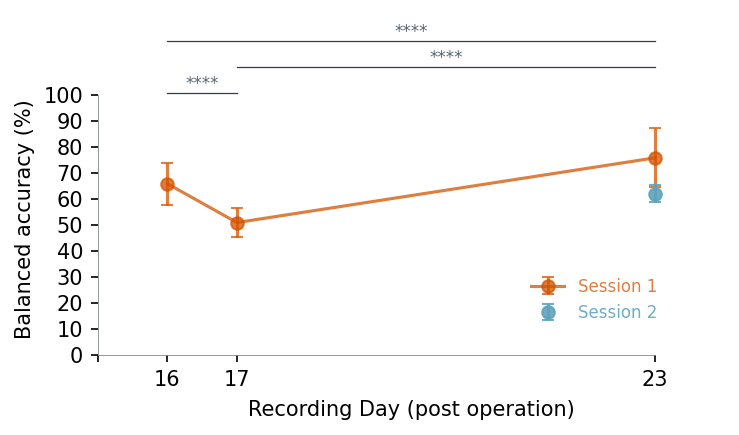

In [160]:
mean_metrics_across_days, sd_metrics_across_days = plot_avg_acc_across_days(compiled_df, paired_test_df, save_figs=save_figs)

In [161]:
# average across seeds
mean_metrics_across_days[[DAY_COL,SEED_COL,SESSION_COL, N_CHS_COL, 'acc_train','acc_val']]

,day,seed,session,n_chs,acc_train,acc_val
0,16,300.818182,01,56,0.897542,66.00
1,17,300.818182,01,56,0.773374,51.03
2,23,300.818182,01,56,0.947691,75.96
3,23,10.000000,02,56,0.817763,62.11


In [162]:
# sd across seeds
sd_metrics_across_days[[DAY_COL,SEED_COL,SESSION_COL, N_CHS_COL, 'acc_train','acc_val']]

,day,seed,session,n_chs,acc_train,acc_val
0,16,291.092393,01,56,0.018945,8.07
1,17,291.092393,01,56,0.022497,5.73
2,23,291.092393,01,56,0.017484,11.42
3,23,0.000000,02,56,0.031302,3.24


# Effect of window length

In [195]:
compiled_df_win = load_results_to_df(data_directory='data/clf_results/day16_sweep_window_size_seed_10',data_type=None, clf_type='svm')

svm_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.7.pkl
svm_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.2.pkl
svm_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.3.pkl
svm_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.12000000000000001.pkl
svm_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.1.pkl
svm_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd. Close']_temporal_True_bin_0.7999999999999998.pkl
svm_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'Uln

In [18]:
assert compiled_df_win[SEED_COL].unique() == [10]
assert compiled_df_win[DAY_COL].unique() == [16]

In [165]:
#MANPLOT: sweep window size
def plot_window_size_sweep(compiled_df_win, save_fig=False, std_as_shaded_region=False):
    """
    Plots the window size sweep accuracy for training and validation sets.

    Parameters:
    compiled_df_win (pd.DataFrame): The compiled DataFrame containing training and validation accuracies.
    color_dict (dict): Dictionary of colors for the plot.
    bin_width_col (str): The column name representing bin width.
    xlab_pad (int): Padding for the x-axis label.
    ylab_pad (int): Padding for the y-axis label.
    fig_size (tuple): Size of the figure.
    """
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)

    lineplot_alpha = 0.6
    shaded_region_alpha = 0.2
    capsize = 2
    marker_size = 3

    mean_train_across_folds = compiled_df_win.groupby([BIN_WIDTH_COL])['acc_train'].mean() * 100
    mean_val_across_folds = compiled_df_win.groupby([BIN_WIDTH_COL])['acc_val'].mean() * 100
    std_train_across_folds = compiled_df_win.groupby([BIN_WIDTH_COL])['acc_train'].std() * 100
    std_val_across_folds = compiled_df_win.groupby([BIN_WIDTH_COL])['acc_val'].std() * 100

    if std_as_shaded_region:
         # Plot train accuracies with std as shaded region
        ax.plot(mean_train_across_folds.index, mean_train_across_folds, '-o',label='Training', color=COLOR_DICT['midnight_blue'],
                ms=marker_size)
        ax.fill_between(mean_train_across_folds.index, mean_train_across_folds - std_train_across_folds,
                        mean_train_across_folds + std_train_across_folds, color=COLOR_DICT['midnight_blue'], alpha=shaded_region_alpha)
        
        # Plot val accuracies with std as shaded region
        ax.plot(mean_val_across_folds.index, mean_val_across_folds, '-o', label='Validation', color=COLOR_DICT['pumpkin'],
                ms=marker_size)
        ax.fill_between(mean_val_across_folds.index, mean_val_across_folds - std_val_across_folds,
                        mean_val_across_folds + std_val_across_folds, color=COLOR_DICT['pumpkin'], alpha=shaded_region_alpha)
        
    else:
        # Plot a lineplot with error bars
        ax.errorbar(mean_train_across_folds.index, mean_train_across_folds, std_train_across_folds, ms=marker_size,
                    label='Training', color=COLOR_DICT['midnight_blue'], fmt='-o', capsize=capsize, alpha=lineplot_alpha)
        ax.errorbar(mean_val_across_folds.index, mean_val_across_folds, std_val_across_folds, ms=marker_size,
                    label='Validation', color=COLOR_DICT['fushia'], fmt='-o', capsize=capsize, alpha=lineplot_alpha)

   
    ax.set_ylim([0, 110])
    sns.despine(ax=ax, trim=False)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xlabel('Window Size (s)', labelpad=XLAB_PAD)
    ax.set_ylabel(ACC_LABEL, labelpad=YLAB_PAD)
    ax.legend(loc='lower right', ncol=1, frameon=False, labelcolor='linecolor', fontsize=8)

    if save_fig:
        fig.savefig(os.path.join(CLF_FIG, f"day16_sweep_windowsize_stdshaded_{std_as_shaded_region}.png"), dpi=300, bbox_inches='tight')


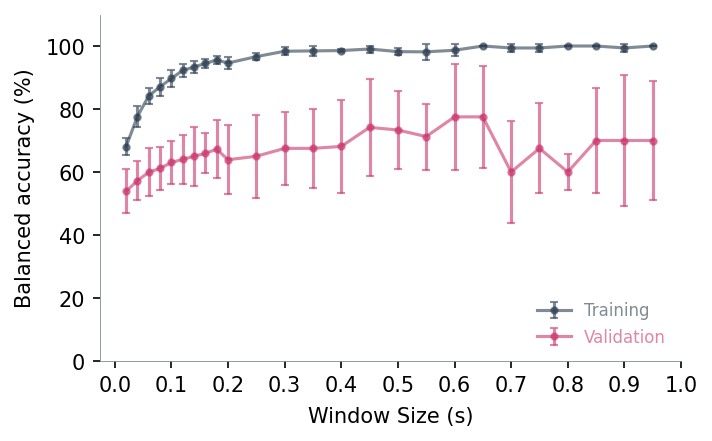

In [168]:
plot_window_size_sweep(compiled_df_win, save_fig=True, std_as_shaded_region=False)

# Comparison bar plots with SNN (diagonal of confusion matrix)

In [196]:
# load snn results
compiled_snn_df = load_results_to_df(data_directory='data/snn_clf_results', clf_type='snn', data_type='meansd_df')

# load svm results
compiled_svm_df = load_results_to_df(data_directory='data/clf_results', clf_type='svm',data_type='meansd_df')
compiled_svm_df

snn_meansd_df_1601_ep_1_seed_10_kcv_5_nchs_56_bin_0.1.pkl
.DS_Store
snn_meansd_df1601_ep_1_seed_10_kcv_5_nchs_56_bin_0.1.pkl
snn_results_df1601_ep_1_seed_10_kcv_5_nchs_56_bin_0.1.pkl
snn_results_df_1601_ep_1_seed_10_kcv_5_nchs_56_bin_0.1.pkl
.DS_Store
day16_sweep_window_size_seed_10
across_days_without_removing_channels
with_removal_channels
svm_meansd_df_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd.']_temporal_True_bin_0.2.pkl
svm_results_df_1601_seed_10_power_kcv_5_nchs_56_acc_df_linear_['Tripod Open', 'ThOpp. Close', 'UlnarFing. Close', 'FingAbd.']_temporal_True_bin_0.2.pkl


,acc_train,acc_val,f1_train,f1_val,prec_train,prec_val,recall_train,recall_val,day,session,seed,bin_width,k_cv,is_temporal,n_chs,feat,kernel,fold
0,0.918750,0.750000,0.930084,0.741086,0.931536,0.812500,0.931034,0.750000,16,01,10,0.2,5,True,56,seed,linear,0
1,0.948611,0.750000,0.950354,0.750000,0.951196,0.769481,0.950192,0.750000,16,01,10,0.2,5,True,56,seed,linear,1
2,0.949074,0.611111,0.948019,0.660247,0.950216,0.655630,0.948148,0.682540,16,01,10,0.2,5,True,56,seed,linear,2
3,0.972222,0.500000,0.973997,0.529149,0.974180,0.629149,0.974074,0.539683,16,01,10,0.2,5,True,56,seed,linear,3
4,0.940972,0.583333,0.940661,0.652356,0.941627,0.666876,0.940741,0.650794,16,01,10,0.2,5,True,56,seed,linear,4


In [188]:
compiled_snn_df

,acc_val,f1_val,prec_val,recall_val,day,session,seed,bin_width,k_cv,n_chs,n_epochs,fold
0,0.322368,0.214782,0.170939,0.322368,16,01,10,0.1,5,56,1,0
1,0.355263,0.249982,0.266152,0.355263,16,01,10,0.1,5,56,1,1
2,0.335526,0.288806,0.249318,0.383459,16,01,10,0.1,5,56,1,2
3,0.328947,0.300938,0.284582,0.375940,16,01,10,0.1,5,56,1,3
4,0.315789,0.261738,0.242857,0.360902,16,01,10,0.1,5,56,1,4


In [ ]:
# Comparison plot in Appendix
svm_mean_150 = [0.66, 0.7, 0.54,0.71]            #100 ms,50% [0.62, 0.65, 0.51, 0.72]
svm_std_150 =  [0.08, 0.09, 0.24, 0.12]          #100 ms, 50%[0.07, 0.08, 0.17, 0.08]
svm_mean_200 = [0.73, 0.7 , 0.47 ,0.71]          # 200 ms time bins
svm_std_200 = [0.11, 0.12 ,0.13 ,0.15]

snn_mean_150 = [0.79, 0.57, 0.54, 0.92]          #100 ms,50%  [0.82, 0.53, 0.51, 0.89]
snn_std_150=  [0.04, 0.29, 0.14, 0.04]          #100 ms,50% [0.04, 0.27, 0.05, 0.03]

snn_mean_200 = [0.82, 0.53, 0.51, 0.89]          # 200 ms time bins
snn_std_200 = [0.04,0.27, 0.05, 0.03]

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
bwidth =0.13


ax.bar(np.arange(4), svm_mean_150, width=bwidth, yerr=svm_std_150, capsize=2, 
        label='Linear SVM (150 ms)', ecolor='#636e72', alpha=0.7, color= COLOR_DICT['wisteria'])
ax.bar(np.arange(4)+bwidth, snn_mean_150, width=bwidth, yerr=snn_std_150, capsize=2, 
       label='Shallow SNN (150 ms)', 
       ecolor='#636e72',  color=COLOR_DICT['green_sea'], alpha=0.7)


ax.bar(np.arange(4)+ 2*bwidth, svm_mean_200, width=bwidth, yerr=svm_std_200, capsize=2, 
        label='Linear SVM (200 ms)', ecolor='#636e72', alpha=0.75, color= COLOR_DICT['wisteria'],
        hatch='\\\\', edgecolor=COLOR_DICT['midnight_blue'])
ax.bar(np.arange(4)+3* bwidth, snn_mean_200, width=bwidth, yerr=snn_std_200, capsize=2, 
       label='Shallow SNN (200 ms)',edgecolor=COLOR_DICT['midnight_blue'],
       ecolor='#636e72',  color=COLOR_DICT['green_sea'], alpha=0.75,

       hatch="..")

# ax.legend(handles=[circ1,circ2], loc='upper left', ncol=2, bbox_to_anchor=(-0.01, 1.22),handleheight=2, handlelength=4)
ax.set_xticks(np.arange(1.5*bwidth,4+1.5*bwidth,1 ), CLASS_TO_GEST.values(), fontsize=6)
plt.ylabel('Correct predictions score', fontsize=8)
plt.legend(loc='upper left', ncol=2, bbox_to_anchor=(-0.01, 1.12),handleheight=1.5, handlelength=3)
plt.show()

# save figure

# fig.savefig(os.path.join(CLF_FIG, f'day{DAY}{SESSION}_svm_vs_snn_150ms_200ms_50_overlap_wider.png'), dpi=300, bbox_inches='tight')

In [ ]:
plot_results_for_win = 150  # ms with 50% overlap

if plot_results_for_win == 150:
        # For 150 ms with 50% overlap
        svm_mean = [0.66, 0.7, 0.54,0.71]            #for 100 ms,50%:  [0.62, 0.65, 0.51, 0.72]
        svm_std =  [0.08, 0.09, 0.24, 0.12]          #for 100 ms, 50%: [0.07, 0.08, 0.17, 0.08]

        snn_mean = [0.79, 0.57, 0.54, 0.92]          #for 100 ms,50%:  [0.82, 0.53, 0.51, 0.89]
        snn_std =  [0.04, 0.29, 0.14, 0.04]          #for 100 ms,50%:  [0.04, 0.27, 0.05, 0.03]
if plot_results_for_win == 100:
        # For 100 ms with 50% overlap
        svm_mean = [0.62, 0.65, 0.51, 0.72]
        svm_std = [0.07, 0.08, 0.17, 0.08]

        snn_mean = [0.82, 0.53, 0.51, 0.89]
        snn_std = [0.04, 0.27, 0.05, 0.03]

# figure styling
svm_color = 'white' #COLOR_DICT['midnight_blue']
svm_edge = COLOR_DICT['midnight_blue']

snn_color = '#628D56' #'white'
snn_hatch = None#'//'
snn_edge = None #COLOR_DICT['midnight_blue']

fig = plt.figure(figsize=(6,3))

ax = fig.add_subplot(111)
bwidth = 0.2
ax.bar(np.arange(4), svm_mean, width=bwidth, yerr=svm_std, capsize=2, 
        label=f'Linear SVM ({plot_results_for_win} ms)', ecolor='#636e72',  alpha=0.6, color= svm_color,
        edgecolor=svm_edge
        )

ax.bar(np.arange(4)+bwidth, snn_mean, width=bwidth, yerr=snn_std, capsize=2, label=f'Shallow SNN ({plot_results_for_win} ms)',
       edgecolor=snn_edge, hatch=snn_hatch,
       ecolor='#636e72',  color=snn_color, alpha=0.7)

ax.set_xticks(np.arange(bwidth/2, 4+bwidth/2, 1))
ax.set_xticklabels(['Tridigital Pinch', 'Thumb Opposition', 'Ulnar Fingers', 'Fingers Abduction'], rotation=45)
ax.set_ylabel('Correct predictions score', labelpad=YLAB_PAD)
# plt.show()
sns.despine(ax=ax, offset=0, trim=False)

fig.legend( ncol=2, frameon=False, bbox_to_anchor=(0.8, 1.1))
#save figure
fig.savefig(os.path.join(CLF_FIG, f'day{DAY}{SESSION}_svm_vs_snn_{plot_results_for_win}ms_50_overlap.png'), dpi=300, bbox_inches='tight')

In [ ]:
print(f"Mean across gestures:\nSVM: {np.mean(svm_mean)*100} +- {np.mean(svm_std)*100}")

print(f"SNN: {np.mean(snn_mean)*100} +- {np.mean(snn_std)*100}")
